In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

## Download some sample data

In [193]:
import priceanalytics.data as data

big_df = data.alpaca_download_single(
    'AAPL',     
    past_days=30, 
    interval=1
)
dfs = data.split_alpaca_on_day(big_df)

## Square Bounds algorithm


$$ \text{Opening and closing price series are defined by}\  O(t) \ \text{and} \ C(t) \ \text{respectively, while}\ \alpha\ \text{is an arbitrary constant.} $$

$$ u(t) = \max( O(t),\ C(t),\ u(t-1) - \frac{u(t-1) - C(t)}{\alpha}) $$

$$ d(t) = \min( O(t),\ C(t),\ d(t-1) + \frac{C(t) - d(t-1)}{\alpha}) $$

$$ U(t) = \max( O^2(t),\ C(t)^2,\ U^2(t-1) - \frac{U(t-1) - C^2(t)}{\alpha}) $$

$$ D(t) = \min( O^2(t),\ C(t)^2,\ D^2(t-1) + \frac{C^2(t) - D(t-1)}{\alpha}) $$

$$ B(t) = \sqrt{U(t)-u^2(t)} $$

$$ b(t) = -\sqrt{D(t)-d^2(t)} $$

$$ \text{Enter a long position when }\ \ \frac{dB}{dt}(t) < 0\ \text{and enter a short position when }\ \ \frac{db}{dt}(t) > 0 \text{.} $$


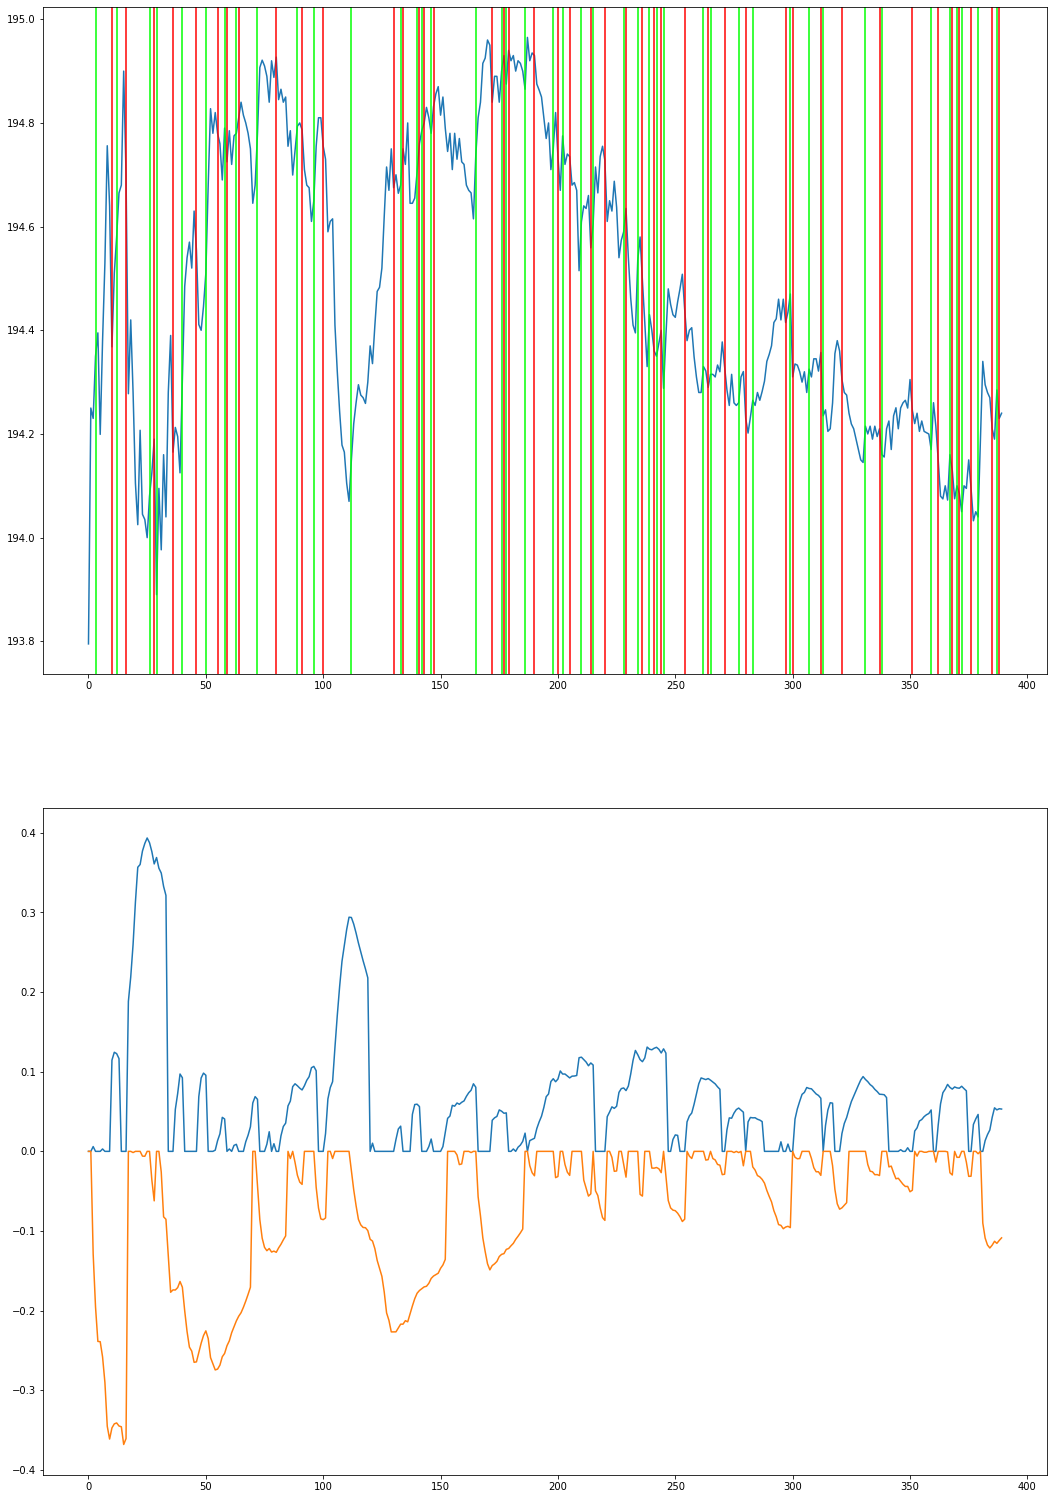

In [194]:
import pandas as pd
import numpy as np
import priceanalytics.plot as plot
import matplotlib.pyplot as plt

def roll(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def sb(close, _open):

    N = len(close)
#     alpha = 2 / (_len + 1)
#     alpha_sig = 2 / (sig_len + 1)
    alpha = 10

    up1, up2, dn1, dn2, bull, bear, sig = np.zeros((7, N))

    up1[0] = dn1[0] = close[0]
    up2[0] = dn2[0] = close[0] ** 2

    #print(alpha, alpha_sig, up1[0], dn1[0], up2[0], dn2[0], sig[0])
       
    for i in range(1, N):
        
        up1[i] = max(close[i], _open[i], up1[i - 1] - (up1[i - 1] - close[i]) / alpha)
        dn1[i] = min(close[i], _open[i], dn1[i - 1] + (close[i] - dn1[i - 1]) / alpha)

        up2[i] = max(close[i] ** 2, _open[i] ** 2, up2[i - 1] - (up2[i - 1] - close[i] ** 2) / alpha)
        dn2[i] = min(close[i] ** 2, _open[i] ** 2, dn2[i - 1] + (close[i] ** 2 - dn2[i - 1]) / alpha)
     
        #print(up1[i], np.sqrt(up2[i]), dn1[i], np.sqrt(dn2[i]))
        
        
        bull[i] = np.sqrt(up2[i] - up1[i] ** 2)
        bear[i] = np.sqrt(dn2[i] - dn1[i] ** 2)

        #sig[i] = sig[i - 1] + alpha_sig * (np.maximum(bull[i], bear[i]) - sig[i - 1])
        
    bear *= -1
        
    bull_1st_ddt = np.gradient(bull)
    bull_2nd_ddt = np.gradient(bull_1st_ddt)
    bull_3rd_ddt = np.gradient(bull_2nd_ddt)

    bear_1st_ddt = np.gradient(bear)
    bear_2nd_ddt = np.gradient(bear_1st_ddt)
    bear_3rd_ddt = np.gradient(bear_2nd_ddt)
    
    bull_ma = pd.Series(bull).rolling(3).mean().to_numpy()
    bear_ma = pd.Series(bear).rolling(3).mean().to_numpy()
        
    inpos = False
    longs, shorts = [], []
    for i in range(1, N-1):
        if bull_1st_ddt[i] < 0 and not inpos:
            inpos = True
            longs.append(i)
        elif bear_1st_ddt[i] > 0 and inpos:
            inpos = False
            shorts.append(i)
            
    with plot.MultiPlot(2, size=(18, 9 * 3)) as m:
        plt.plot(close)
        for long in longs:
            plt.axvline(x=long, color="#00FF00")
        for short in shorts:
            plt.axvline(x=short, color="#FF0000")
        
        #plt.plot(up1)
        #plt.plot(np.sqrt(up2))
            
        #plt.plot(dn1)
        #plt.plot(np.sqrt(dn2))
     
        m.next()
        
        plt.plot(bull)
#         plt.plot(bull_ma)

        plt.plot(bear)    
    
#         plt.plot(bear_ma)

        
#         m.next()
        
#         plt.plot(bull_1st_ddt)
#         plt.plot(bull_2nd_ddt)
#         #bear_1st_ddt, bear_2nd_ddt
        
      
    
    #return df


def test_sb(df):
    
    
    close = df['close'].to_numpy()
    _open = df['open'].to_numpy()
    
    sb(close, _open)

test_sb(dfs[-12].copy())

## Todo tommorow

- play around w/ the formula a little more
- maybe mess with alpha a bit (; 
- implement a proper backtesting notebook
- maybe make a testing script for tuning alpha parameters + many datapoints
- implement gradient algorithm in go (cry) with testcases (supercry)